### Basic Text Classification

In [25]:
import matplotlib.pyplot as plt

import os , re , shutil ,string

import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses

In [7]:
print(os.path)

<module 'posixpath' from '/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/posixpath.py'>


In [5]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"


dataset = tf.keras.utils.get_file("aclImdb_v1" , url , untar=True , cache_dir='.' , cache_subdir='')

84125825/84125825 ━━━━━━━━━━━━━━━━━━━━ 55s 1us/step


In [8]:
dataset_dir = os.path.join(os.path.dirname(dataset) , 'aclImdb')

In [9]:
os.listdir(dataset_dir)

['imdbEr.txt', 'test', 'imdb.vocab', 'README', 'train']

In [10]:
train_dir = os.path.join(dataset_dir , 'train')

In [11]:
os.listdir(train_dir)

['urls_unsup.txt',
 'neg',
 'urls_pos.txt',
 'unsup',
 'urls_neg.txt',
 'pos',
 'unsupBow.feat',
 'labeledBow.feat']

In [12]:
sample_file = os.path.join(train_dir , 'pos/1181_9.txt')
with open(sample_file) as f:
    print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [13]:
remove_dir = os.path.join(train_dir , 'unsup')

shutil.rmtree(remove_dir)

In [14]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train' , 
    batch_size = batch_size ,
    validation_split = 0.2 ,
    subset = 'training' ,
    seed = seed 
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [15]:
for text_batch , label_batch in raw_train_ds.take(1):
    for i in range(3):
        print("Review" , text_batch.numpy()[i])
        print("Label" , label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

2024-07-09 19:12:19.682542: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [17]:
print("Label 0 corresponds to " , raw_train_ds.class_names[0])
print("Label 1 corresponds to " , raw_train_ds.class_names[1])

Label 0 corresponds to  neg
Label 1 corresponds to  pos


In [18]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train' , 
    batch_size = batch_size ,
    validation_split = 0.2 ,
    subset = 'validation' ,
    seed = seed 
)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [19]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test' , 
    batch_size = batch_size
)

Found 25000 files belonging to 2 classes.


In [26]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase , "<br />" , "") # this is for wherever we have <br /> in the text
    return tf.strings.regex_replace(stripped_html , '[%s]' % re.escape(string.punctuation) , '') # this is for removing punctuations like . , ! etc

In [23]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize = custom_standardization ,
    max_tokens = max_features ,
    output_mode = 'int' ,
    output_sequence_length = sequence_length
)

In [27]:
# Make a text-only dataset (without labels) and call adapt

train_text = raw_train_ds.map(lambda x, y :x)
vectorize_layer.adapt(train_text)

2024-07-09 19:24:17.586022: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [28]:
def vectorize_text(text , label):
    text = tf.expand_dims(text , -1)
    return vectorize_layer(text) , label

In [29]:

text_batch , label_batch = next(iter(raw_train_ds))
first_review , first_label = text_batch[0] , label_batch[0]
print("Review" , first_review)
print("Label" , raw_train_ds.class_names[first_label])
print("Vectorized review" , vectorize_text(first_review , first_label))

Review tf.Tensor(b'Great movie - especially the music - Etta James - "At Last". This speaks volumes when you have finally found that special someone.', shape=(), dtype=string)
Label neg
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  85,   17,  257,    2,  222,    1,  574,   30,  227,   10, 2401,
           1,   52,   23,   25,  426,  248,   12,  306,  279,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
       

In [30]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  batman
 313 --->  audience
Vocabulary size: 10000


In [31]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [32]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Create the model

In [33]:
embedding_dim = 16


In [34]:
model = tf.keras.Sequential([
  layers.Embedding(max_features, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1, activation='sigmoid')])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [35]:
model.compile(loss=losses.BinaryCrossentropy(),
              optimizer='adam',
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.5)])

In [36]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - binary_accuracy: 0.5902 - loss: 0.6815 - val_binary_accuracy: 0.7242 - val_loss: 0.6148
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - binary_accuracy: 0.7549 - loss: 0.5815 - val_binary_accuracy: 0.8134 - val_loss: 0.4993
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - binary_accuracy: 0.8168 - loss: 0.4720 - val_binary_accuracy: 0.8382 - val_loss: 0.4265
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - binary_accuracy: 0.8469 - loss: 0.4019 - val_binary_accuracy: 0.8468 - val_loss: 0.3866
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - binary_accuracy: 0.8629 - loss: 0.3553 - val_binary_accuracy: 0.8556 - val_loss: 0.3590
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - binary_accuracy: 0.8760 - loss: 0.3230 - val_binary_accuracy: 0.8532 - val_loss: 0.3450
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - binary_accuracy: 0.8871 - loss: 0.2981 - val_binary_accuracy: 0.8572 - val_loss: 0.3317
Epoch 

In [37]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - binary_accuracy: 0.8540 - loss: 0.3316
Loss:  0.33736008405685425
Accuracy:  0.8521999716758728


In [38]:
history_dict = history.history
history_dict.keys()

dict_keys(['binary_accuracy', 'loss', 'val_binary_accuracy', 'val_loss'])

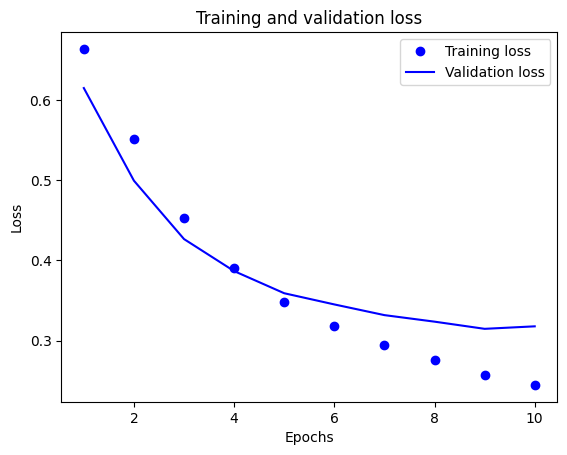

In [40]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

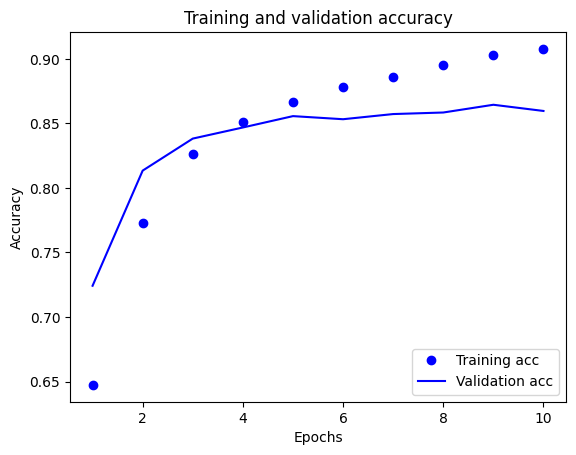

In [41]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [48]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)



In [54]:
# Test it with [`raw_test_ds`]
results   = export_model.evaluate(raw_test_ds)
print("Accuracy : " , results[1])
print("Loss : " , results[0])

  1/782 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.3438 - binary_accuracy: 0.0000e+00 - loss: 0.0000e+00

782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4918 - binary_accuracy: 0.0000e+00 - loss: 0.0000e+00
Accuracy :  0.0
Loss :  0.0


In [45]:
examples = tf.constant([
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
])

export_model.predict(examples)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


array([[0.5831335],
       [0.5481824],
       [0.5354567]], dtype=float32)